In [2]:
# run sanitaion_and_fiedler_value.ipynb before running this
import pickle
import numpy as np
from scipy.linalg import eigh

In [3]:
def compute_conductance(A_sub, mask1, mask2):
    """
    Compute conductance of a cut defined by mask1 and mask2.
    
    Conductance = cut(S, S') / min(vol(S), vol(S'))
    """
    cut_weight = np.sum(A_sub[np.ix_(mask1, mask2)])
    vol1 = np.sum(A_sub[mask1, :])
    vol2 = np.sum(A_sub[mask2, :])
    min_vol = min(vol1, vol2)
    if min_vol == 0:
        return float('inf')
    return cut_weight / min_vol

# ======================================================
# Recursive Fiedler Segmentation
# ======================================================

def recursive_fiedler(A, nodes=None, normalized=False, lambda2_thresh=None, conductance_thresh=None, verbose=False):
    """
    Minimal recursive Fiedler bisection.
    Stopping rule: λ2 > lambda2_thresh or conductance > conductance_thresh
    """
    if nodes is None:
        nodes = np.arange(A.shape[0])
    nodes = np.asarray(nodes)
    n_nodes = len(nodes)
    
    # Stop trivially small clusters
    if n_nodes <= 2:
        return [nodes]
    
    # Subgraph
    A_sub = A[np.ix_(nodes, nodes)]
    degs = A_sub.sum(axis=1)
    
    # Laplacian
    if not normalized:
        L = np.diag(degs) - A_sub
    else:
        with np.errstate(divide='ignore'):
            inv_sqrt = 1.0 / np.sqrt(degs + 1e-12)
        inv_sqrt[~np.isfinite(inv_sqrt)] = 0.0
        D_inv_sqrt = np.diag(inv_sqrt)
        L = np.eye(n_nodes) - D_inv_sqrt @ A_sub @ D_inv_sqrt
    
    # Eigen decomposition
    vals, vecs = eigh(L)
    lambda2 = vals[1]
    
    if verbose:
        print(f"n={n_nodes} λ2={lambda2:.4f}")
    
    # Stop if λ2 is too large (cluster is tight)
    if lambda2_thresh:
        if lambda2 > lambda2_thresh:
            return [nodes]
    
    # Split by Fiedler sign
    fiedler = vecs[:, 1]
    mask1 = fiedler > 0
    mask2 = fiedler <= 0
    cluster1 = nodes[mask1]
    cluster2 = nodes[mask2]
    
    # Stop if split is trivial
    if len(cluster1) == 0 or len(cluster2) == 0:
        return [nodes]
    
    # Check conductance if threshold provided
    if conductance_thresh:
        conductance = compute_conductance(A_sub, mask1, mask2)
        if verbose:
            print(f"  conductance={conductance:.4f}")
        if conductance > conductance_thresh:
            return [nodes]
    
    # Recurse
    return recursive_fiedler(A, cluster1, normalized, lambda2_thresh, conductance_thresh, verbose) + \
           recursive_fiedler(A, cluster2, normalized, lambda2_thresh, conductance_thresh, verbose)


In [23]:
with open("samples_by_period.pkl", "rb") as f:
    samples_by_period = pickle.load(f)
with open("corr_by_period.pkl", "rb") as f:
    corr_by_period = pickle.load(f)

clusterings_by_period = {}
for period in samples_by_period.keys():
    corr = corr_by_period[period].values
    samples = samples_by_period[period]
    A = np.abs(corr)
    np.fill_diagonal(A, 0)
    
    # threshold 0.95 is chosen as it is the highest lambda2 observed across periods and is also at a time where market is relatively stable and homogeneous
    # conductance_thresh is set to None to disable conductance based stopping criteria, since it was observed to be too restrictive due to the fact that correlation matrices are dense
    # base conductance is observed to be quite high (>0.5) even for intuitive splits
    clusters = recursive_fiedler(A, normalized=True, lambda2_thresh=0.95, conductance_thresh=None, verbose=False)
    clusterings_by_period[period] = {
        'samples': samples,
        'clusters': clusters
    }

fiedler_value_by_period = {}
for period in samples_by_period.keys():
    corr = corr_by_period[period].values
    A = np.abs(corr)
    np.fill_diagonal(A, 0)
    
    from scipy.sparse import csgraph
    L_norm = csgraph.laplacian(A, normed=True)
    
    # eigenvalues
    eigvals = np.linalg.eigvalsh(L_norm)
    
    # Fiedler value (second-smallest)
    fiedler_value_by_period[period] = eigvals[1]

# # Cluster information
# for period, data in clusterings_by_period.items():
#     samples = data['samples']
#     clusters = data['clusters']
#     print(f"Period: {period}, Number of clusters: {len(clusters)}")
#     for i, cluster in enumerate(clusters):
#         print(f"  Cluster {i+1}: Size {len(cluster)}")

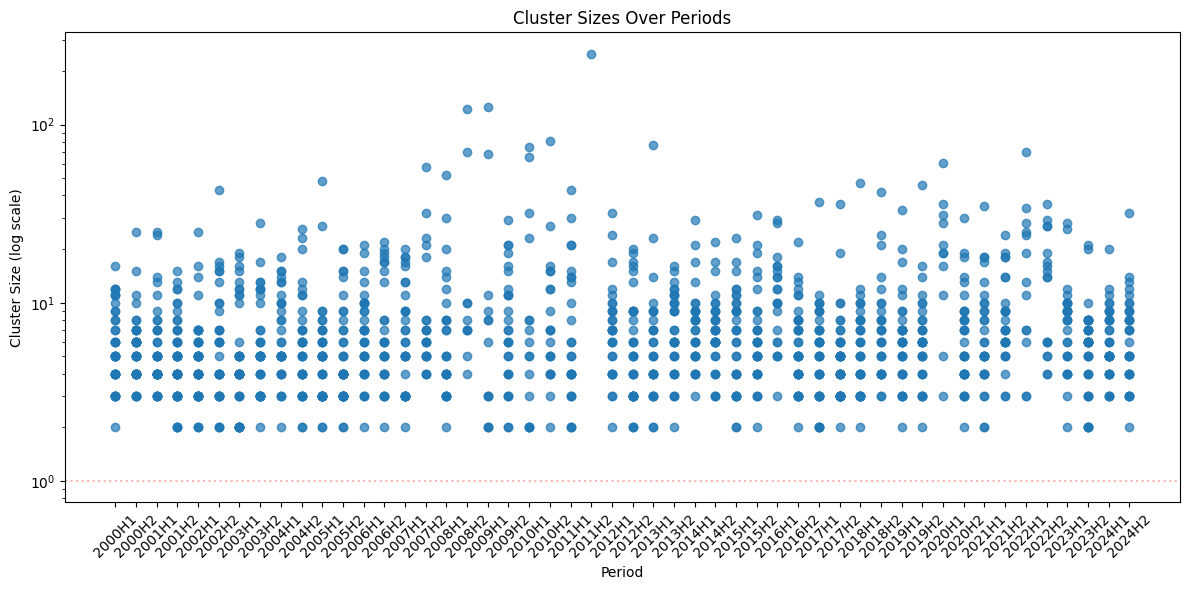

In [24]:
import matplotlib.pyplot as plt

periods = list(clusterings_by_period.keys())

plt.figure(figsize=(12, 6))

for i, period in enumerate(periods):
    sizes = [len(cluster) for cluster in clusterings_by_period[period]['clusters']]
    plt.scatter([i]*len(sizes), sizes, color='C0', alpha=0.7)

plt.yscale('log')  # if cluster sizes vary a lot
plt.xticks(ticks=range(len(periods)), labels=periods, rotation=45)
plt.xlabel('Period')
plt.ylabel('Cluster Size (log scale)')
plt.axhline(y=1, color='r', linestyle=':', alpha=0.3, label='Singleton')
plt.title('Cluster Sizes Over Periods')
plt.tight_layout()
plt.show()

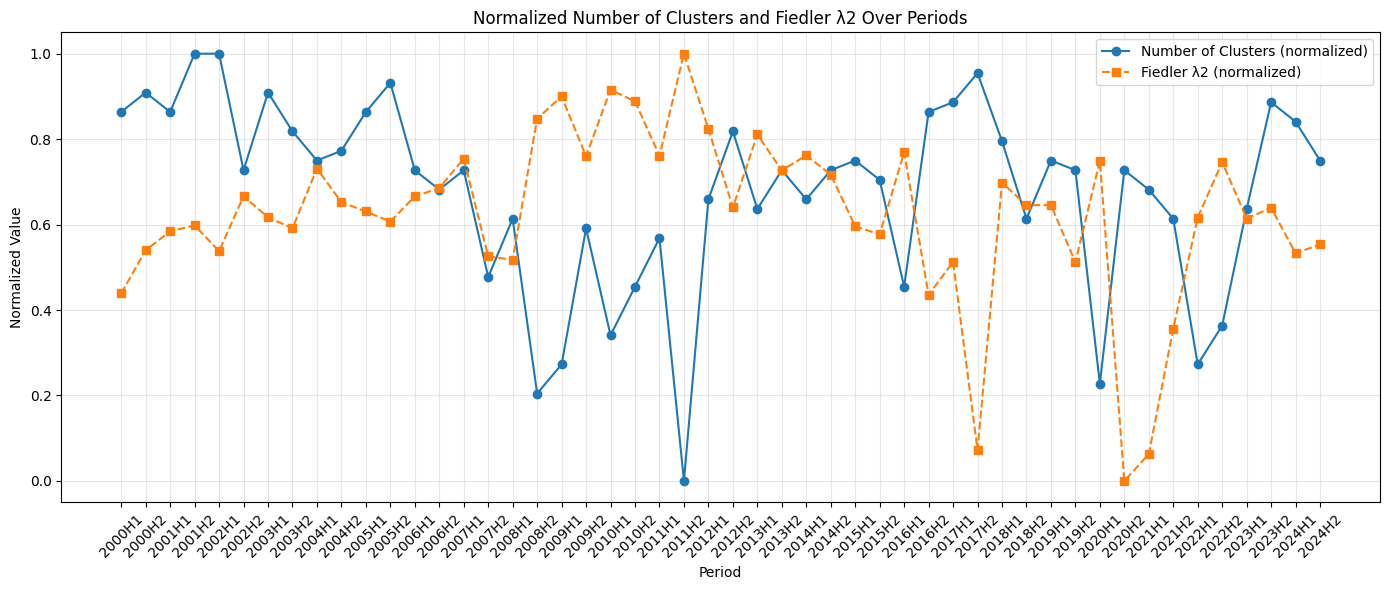

In [25]:

periods = list(clusterings_by_period.keys())
num_clusters = np.array([len(clusterings_by_period[period]['clusters']) for period in periods])
fiedler_values = np.array([fiedler_value_by_period[period] for period in periods])

# Normalize both series to 0-1
num_clusters_norm = (num_clusters - num_clusters.min()) / (num_clusters.max() - num_clusters.min())
fiedler_values_norm = (fiedler_values - fiedler_values.min()) / (fiedler_values.max() - fiedler_values.min())

plt.figure(figsize=(14, 6))
plt.plot(periods, num_clusters_norm, marker='o', linestyle='-', label='Number of Clusters (normalized)')
plt.plot(periods, fiedler_values_norm, marker='s', linestyle='--', label='Fiedler λ2 (normalized)')

plt.xticks(rotation=45)
plt.xlabel('Period')
plt.ylabel('Normalized Value')
plt.title('Normalized Number of Clusters and Fiedler λ2 Over Periods')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


2000H1:
  Clusters: 39
  Within-cluster correlation: 0.150 (±0.068)
  Between-cluster correlation: 0.059 (±0.049)
  Separation (within - between): 0.091

2000H2:
  Clusters: 41
  Within-cluster correlation: 0.099 (±0.070)
  Between-cluster correlation: 0.042 (±0.036)
  Separation (within - between): 0.057

2001H1:
  Clusters: 39
  Within-cluster correlation: 0.107 (±0.080)
  Between-cluster correlation: 0.045 (±0.039)
  Separation (within - between): 0.063

2001H2:
  Clusters: 45
  Within-cluster correlation: 0.047 (±0.046)
  Between-cluster correlation: 0.020 (±0.019)
  Separation (within - between): 0.027

2002H1:
  Clusters: 45
  Within-cluster correlation: 0.081 (±0.055)
  Between-cluster correlation: 0.030 (±0.023)
  Separation (within - between): 0.050

2002H2:
  Clusters: 33
  Within-cluster correlation: 0.105 (±0.112)
  Between-cluster correlation: 0.060 (±0.045)
  Separation (within - between): 0.044

2003H1:
  Clusters: 41
  Within-cluster correlation: 0.099 (±0.064)
  Betwe

/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sagnik/Work and Research/Projects/spectral-analysis-market-information-diffusion/env/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrme


2014H1:
  Clusters: 30
  Within-cluster correlation: 0.177 (±0.057)
  Between-cluster correlation: 0.109 (±0.034)
  Separation (within - between): 0.068

2014H2:
  Clusters: 33
  Within-cluster correlation: 0.246 (±0.068)
  Between-cluster correlation: 0.145 (±0.041)
  Separation (within - between): 0.102

2015H1:
  Clusters: 34
  Within-cluster correlation: 0.159 (±0.070)
  Between-cluster correlation: 0.078 (±0.035)
  Separation (within - between): 0.081

2015H2:
  Clusters: 32
  Within-cluster correlation: 0.216 (±0.112)
  Between-cluster correlation: 0.120 (±0.043)
  Separation (within - between): 0.096

2016H1:
  Clusters: 21
  Within-cluster correlation: 0.195 (±0.053)
  Between-cluster correlation: 0.128 (±0.045)
  Separation (within - between): 0.068

2016H2:
  Clusters: 39
  Within-cluster correlation: 0.139 (±0.076)
  Between-cluster correlation: 0.065 (±0.029)
  Separation (within - between): 0.075

2017H1:
  Clusters: 40
  Within-cluster correlation: 0.135 (±0.096)
  Betwe

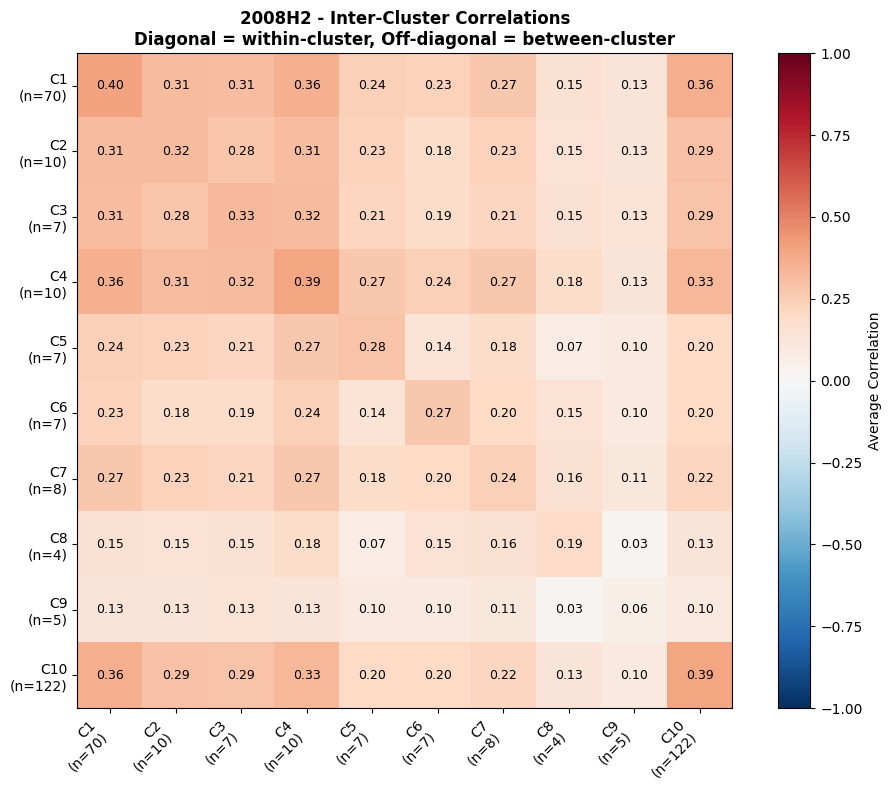

In [26]:
def compute_intercluster_correlations(period, clusterings_by_period, corr_by_period):
    """
    Compute average correlation between and within clusters.
    
    Returns:
    --------
    within_cluster_corrs : list
        Average correlation within each cluster
    between_cluster_corrs : 2D array
        Average correlation between each pair of clusters
    """
    data = clusterings_by_period[period]
    clusters = data['clusters']
    corr = corr_by_period[period].values
    
    n_clusters = len(clusters)
    
    # Within-cluster correlations
    within_cluster_corrs = []
    for cluster in clusters:
        if len(cluster) > 1:
            cluster_corr = corr[np.ix_(cluster, cluster)]
            # Get upper triangle (exclude diagonal)
            triu_indices = np.triu_indices_from(cluster_corr, k=1)
            avg_corr = np.mean(cluster_corr[triu_indices])
        else:
            avg_corr = np.nan
        within_cluster_corrs.append(avg_corr)
    
    # Between-cluster correlations
    between_cluster_corrs = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j:
                between_cluster_corrs[i, j] = within_cluster_corrs[i]
            else:
                cross_corr = corr[np.ix_(clusters[i], clusters[j])]
                between_cluster_corrs[i, j] = np.mean(cross_corr)
    
    return within_cluster_corrs, between_cluster_corrs

def plot_intercluster_correlation(period, clusterings_by_period, corr_by_period, figsize=(10, 8)):
    """
    Visualize inter-cluster correlation matrix.
    """
    within, between = compute_intercluster_correlations(period, clusterings_by_period, corr_by_period)
    clusters = clusterings_by_period[period]['clusters']
    
    fig, ax = plt.subplots(figsize=figsize)
    
    im = ax.imshow(between, cmap='RdBu_r', vmin=-1, vmax=1)
    
    # Labels
    labels = [f'C{i+1}\n(n={len(clusters[i])})' for i in range(len(clusters))]
    ax.set_xticks(range(len(clusters)))
    ax.set_yticks(range(len(clusters)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    
    # Add text annotations
    for i in range(len(clusters)):
        for j in range(len(clusters)):
            text = ax.text(j, i, f'{between[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=9)
    
    ax.set_title(f'{period} - Inter-Cluster Correlations\n'
                 f'Diagonal = within-cluster, Off-diagonal = between-cluster',
                 fontsize=12, fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Average Correlation')
    plt.tight_layout()
    return fig

def summarize_all_periods(clusterings_by_period, corr_by_period):
    """
    Print summary statistics for all periods.
    """
    for period in clusterings_by_period.keys():
        within, between = compute_intercluster_correlations(period, clusterings_by_period, corr_by_period)
        
        # Get off-diagonal (between-cluster) values
        n = len(within)
        mask = ~np.eye(n, dtype=bool)
        between_vals = between[mask]
        
        print(f"\n{period}:")
        print(f"  Clusters: {n}")
        print(f"  Within-cluster correlation: {np.nanmean(within):.3f} (±{np.nanstd(within):.3f})")
        print(f"  Between-cluster correlation: {np.mean(between_vals):.3f} (±{np.std(between_vals):.3f})")
        print(f"  Separation (within - between): {np.nanmean(within) - np.mean(between_vals):.3f}")

# Usage:
# ======

# Summary for all periods
summarize_all_periods(clusterings_by_period, corr_by_period)

# Visualize specific period
plot_intercluster_correlation('2008H2', clusterings_by_period, corr_by_period)
plt.show()

In [74]:
def simulate_stress_diffusion(corr_matrix, initial_stress, n_steps=10, decay=0.9):
    """
    Diffuses stress over the correlation network using a Markov random walk.
    """
    # Convert to numpy, keep absolute value
    A = np.abs(corr_matrix.values.copy())
    np.fill_diagonal(A, 0)

    # # thresholding to retain significant correlations
    threshold = 0.3  # example threshold
    A[A < threshold] = 0

    # Row-normalize → transition probability matrix P
    row_sums = A.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    P = A / row_sums
    
    n = len(initial_stress)
    stress_history = np.zeros((n_steps + 1, n))
    stress_history[0] = initial_stress.copy()
    
    stress = initial_stress.copy()
    for t in range(1, n_steps + 1):
        stress = decay * (P @ stress)   # correct direction
        stress_history[t] = stress
    
    return stress_history

In [75]:
period = list(samples_by_period.keys())[-1]   # or choose one
samples = samples_by_period[period]
corr = corr_by_period[period]

# print(set(samples) - set(corr.index))


# Make sure correlation matrix is aligned in the same ticker order:
corr = corr.loc[samples, samples]

# Pick a firm
firm_name = "NVDA"   # must be in both samples list AND corr index
firm_idx = samples.index(firm_name)

# Initial stress vector
initial_stress = np.zeros(len(samples))
initial_stress[firm_idx] = 1.0

# Run diffusion
stress_history = simulate_stress_diffusion(
    corr_matrix=corr,
    initial_stress=initial_stress,
    n_steps=15,
    decay=0.85
)

final_stress = stress_history[-1]
top_idx = np.argsort(final_stress)[-10:][::-1]

print(f"Stress originating from: {firm_name}\n")
print("Top 10 most stressed firms:")
for rank, idx in enumerate(top_idx, 1):
    print(f"{rank}. {samples[idx]}: {final_stress[idx]:.4f}")

Stress originating from: NVDA

Top 10 most stressed firms:
1. NTAP: 0.0012
2. ANSS: 0.0012
3. CDNS: 0.0012
4. NVDA: 0.0012
5. AMAT: 0.0012
6. KLAC: 0.0012
7. LRCX: 0.0012
8. MPWR: 0.0012
9. OPCH: 0.0012
10. TER: 0.0011


In [76]:
# stress_history

# since correlation matrices are dense, stress diffuses quite quickly and evenly
# meaning in the end, most nodes have similar stress levels and quick intervention is needed to prevent widespread diffusion

# presence of many small correlation values causes stress to diffuse too quickly and evenly
# need to threshold correlation matrix to retain only significant correlations
# also stress diffusion is not always linear in practice
# decay is a function of the firm's characteristics and market conditions
# the diffused stress can be model to estimate risk

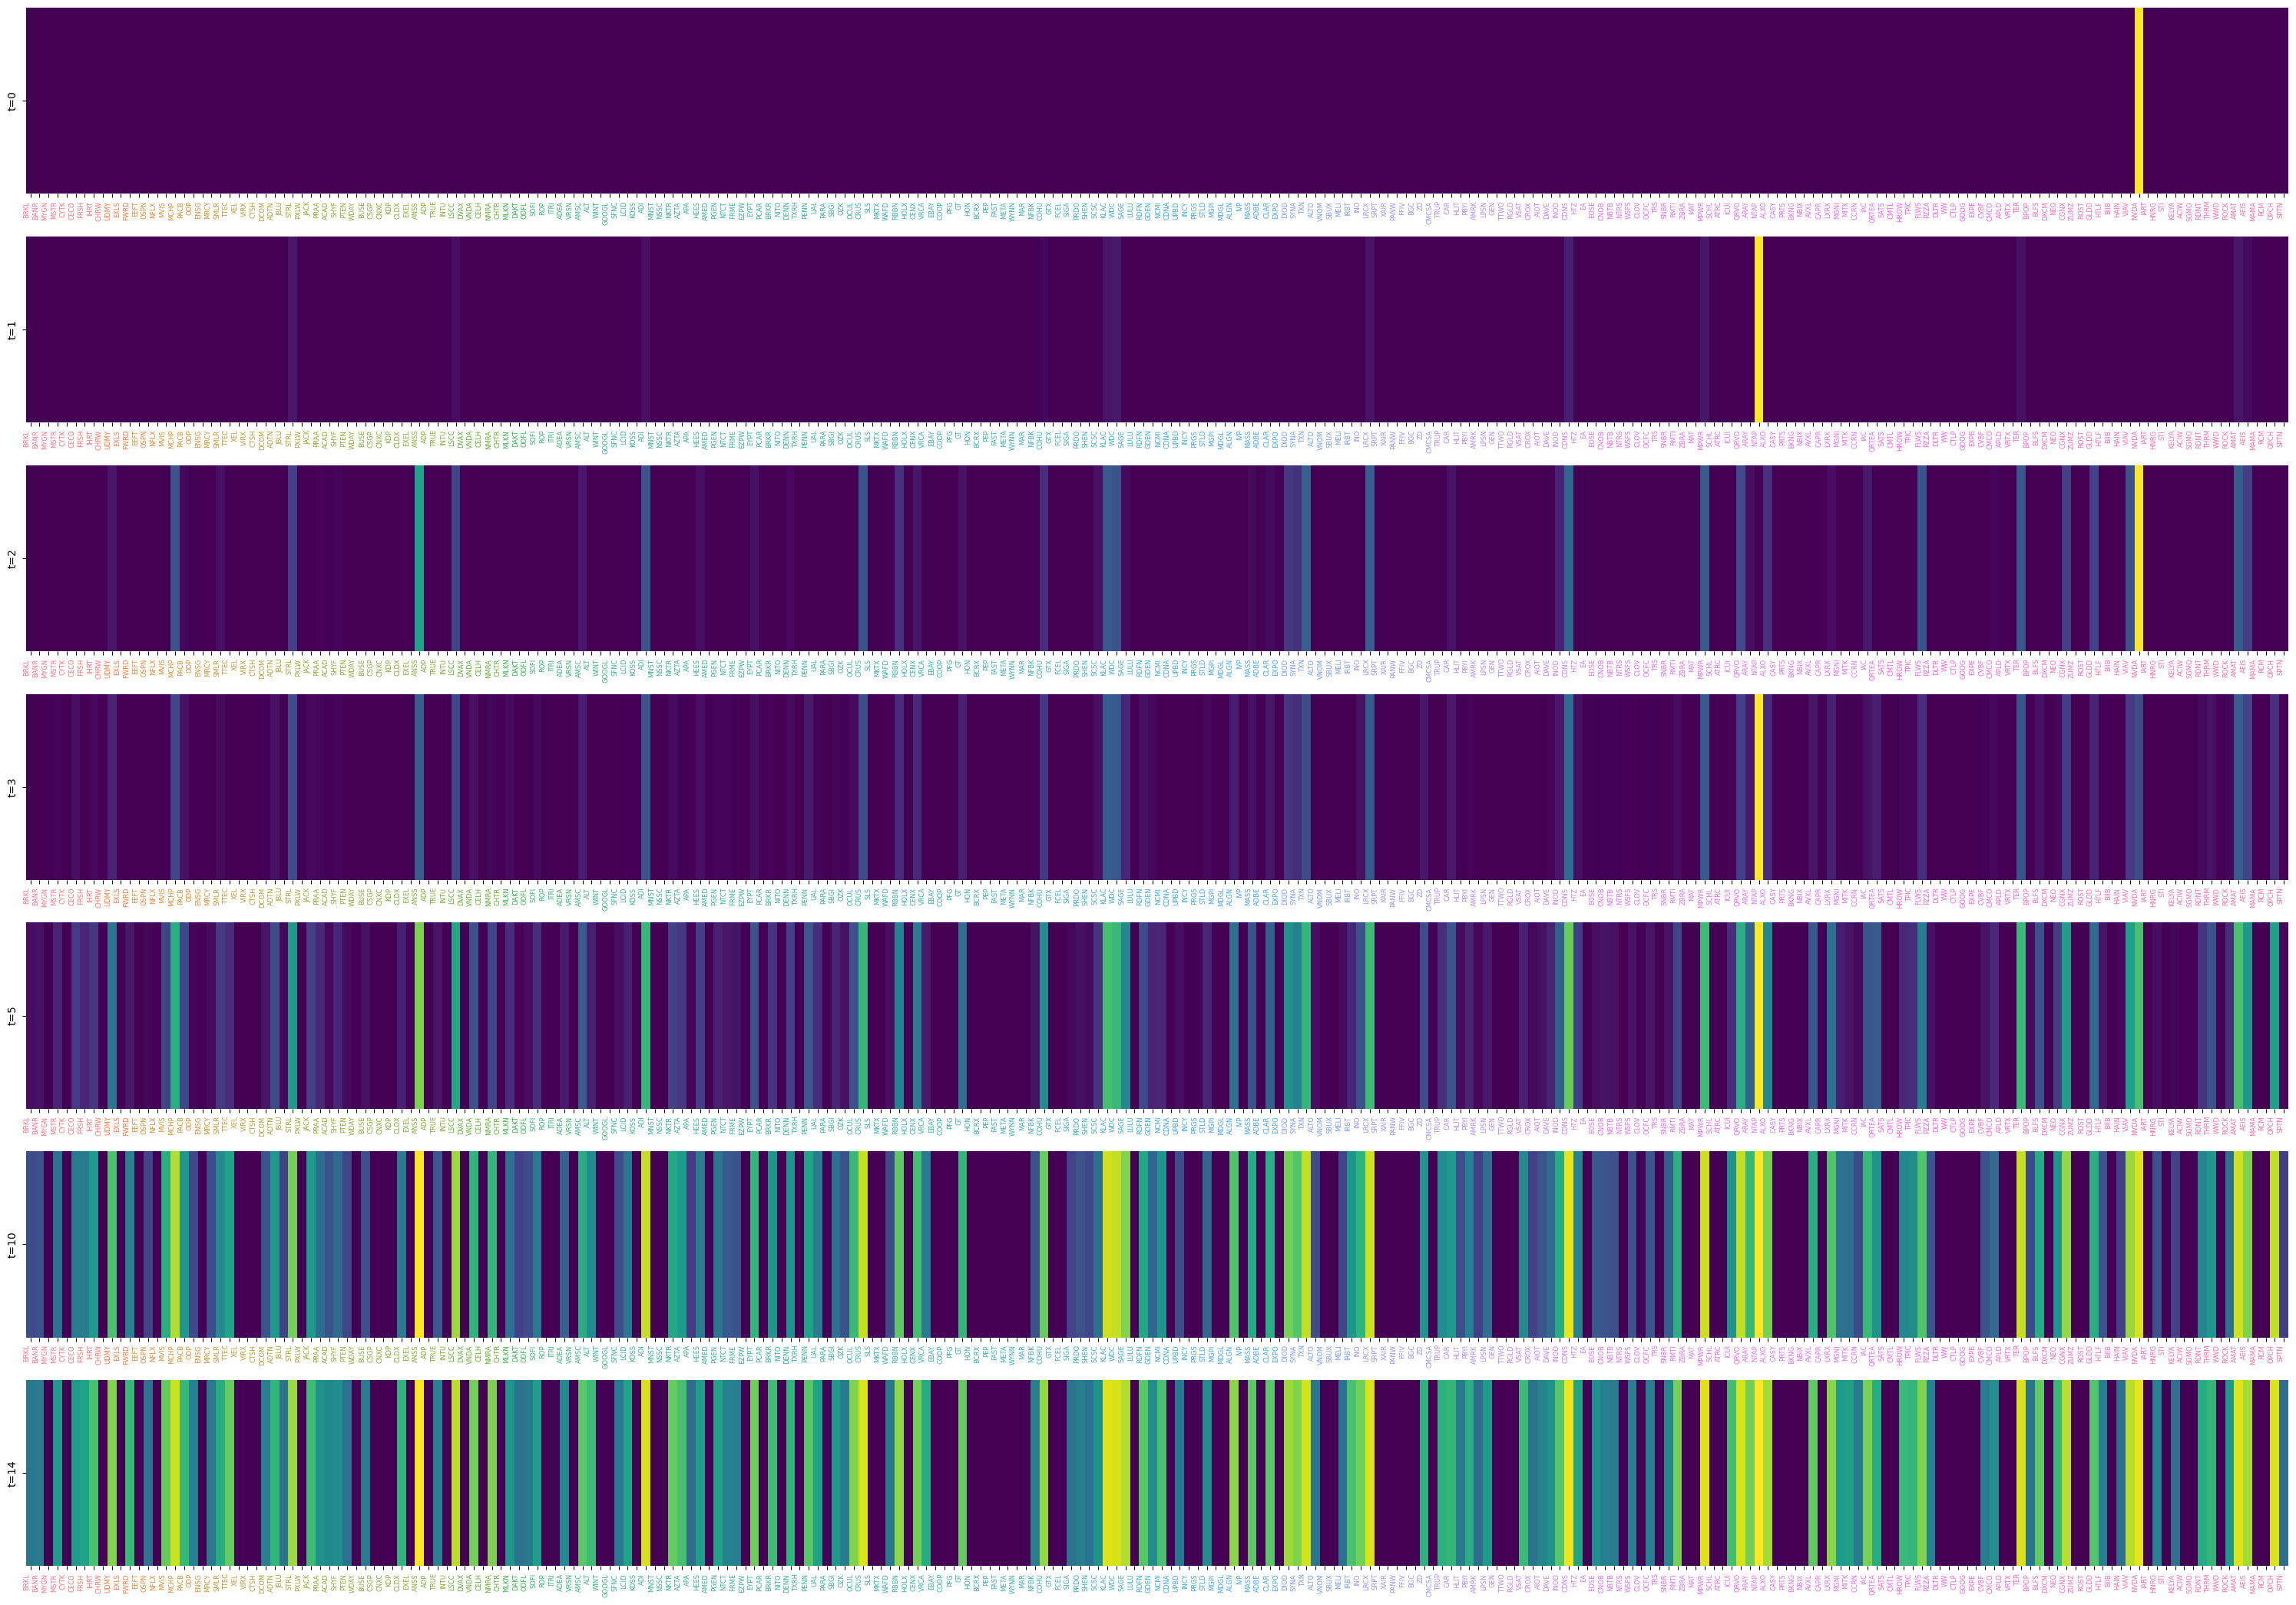

In [77]:
import seaborn as sns

period = list(samples_by_period.keys())[-1]
samples = samples_by_period[period]

# Create a mapping: ticker -> cluster_id
cluster_arrays = clusterings_by_period[period]['clusters']
ticker_to_cluster = {}
for cluster_id, cluster_indices in enumerate(cluster_arrays):
    for idx in cluster_indices:
        ticker = samples[idx]  # map index to ticker in the samples list
        ticker_to_cluster[ticker] = cluster_id

# Sort samples by cluster ID so same-cluster tickers are grouped together
samples_sorted = sorted(samples, key=lambda x: ticker_to_cluster[x])

# Now create a list of cluster ids in the sorted order
clusters = [ticker_to_cluster[ticker] for ticker in samples_sorted]

# Map cluster IDs to colors
unique_clusters = np.unique(clusters)
color_palette = sns.color_palette("husl", len(unique_clusters))
cluster_to_color = {c: color_palette[i] for i, c in enumerate(unique_clusters)}

# Create a mapping from original sample order to sorted order
sample_to_idx = {ticker: i for i, ticker in enumerate(samples)}
sorted_indices = [sample_to_idx[ticker] for ticker in samples_sorted]

steps_to_plot = [0, 1, 2, 3, 5, 10, 14]

fig, axes = plt.subplots(len(steps_to_plot), 1, figsize=(30, 3*len(steps_to_plot)))

for ax, step in zip(axes, steps_to_plot):
    # Reorder the stress values according to sorted samples
    stress_reordered = stress_history[step][sorted_indices]
    
    sns.heatmap(
        stress_reordered.reshape(1, -1),
        cmap="viridis",
        cbar=False,
        ax=ax,
        xticklabels=samples_sorted,
        yticklabels=[f"t={step}"],
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=6)

    # Color tickers according to cluster
    for tick_label, ticker in zip(ax.get_xticklabels(), samples_sorted):
        tick_label.set_color(cluster_to_color[ticker_to_cluster[ticker]])

plt.tight_layout()
plt.show()

In [53]:
clusterings_by_period

{'2000H1': {'samples': ['ICBC',
   'RSLN',
   'CPSS',
   'RCBK',
   'FMER',
   'UNIT',
   'GLDB',
   'UCBH',
   'QCSB',
   'RSFC',
   'BKNG',
   'WABC',
   'UCFC',
   'FULT',
   'WCAP',
   'SIVB',
   'PIOG',
   'HARB',
   'BRKL',
   'EWBC',
   'HBAN',
   'CITZ',
   'SCFS',
   'ACRI',
   'ALLC',
   'RIGS',
   'MDCM',
   'PBCT',
   'REXI',
   'OCFC',
   'FITB',
   'CFFN',
   'RGBK',
   'PFFB',
   'EELN',
   'CBSS',
   'BKLY',
   'TLAB',
   'ATAC',
   'CSAR',
   'KAMNA',
   'CYTC',
   'ATGN',
   'APWR',
   'MOND',
   'OAKT',
   'IFLO',
   'GTNR',
   'NCDI',
   'LRCX',
   'CAMD',
   'SCSS',
   'ATML',
   'DBII',
   'DMIC',
   'IMNR',
   'ICOS',
   'TNCX',
   'KLIC',
   'ZBRA',
   'PMCS',
   'PCTH',
   'CLPA',
   'BMRN',
   'OSTE',
   'MXIM',
   'GLIA',
   'DMED',
   'CGRM',
   'CVSN',
   'ESTI',
   'AVID',
   'ZOOX',
   'MNTR',
   'CEPH',
   'WGNR',
   'ATRX',
   'SSCC',
   'ELSI',
   'ELMG',
   'SMPS',
   'SYXI',
   'TLCM',
   'PROX',
   'ARRO',
   'TOPP',
   'GZTR',
   'FEIC',
   'FOCL',